<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros... 

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

**Grupo 26**

María Candelaria Arpajou

Hugo Alberto Folonier

Gustavo Jaca

# 1.-Inicialización del entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [ ]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [ ]:
from sklearn.cluster import KMeans,MeanShift,DBSCAN
from sklearn import decomposition

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# 2.-Preparación de los datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [ ]:
#url='https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset'
#df=pd.read_csv(url)
df_completo=pd.read_csv('players_22.csv')
df_completo.head(5)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [ ]:
print(df_completo.columns)
print(len(df_completo.columns), 'variables')

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)
110 variables


In [ ]:
# Dropeamos algunas columnas que no vamos a utilizar
df = df_completo.copy()
df = df.drop(['player_url','dob','club_jersey_number','club_loaned_from','club_joined',
              'club_contract_valid_until','player_tags','player_traits',
              'work_rate','body_type','real_face','player_face_url',
              'club_logo_url','club_flag_url','nation_logo_url','nation_flag_url',
              'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
              'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
              'lcb', 'cb', 'rcb', 'rb', 'gk'],axis=1)
print(df.columns)
print(len(df.columns), 'variables')

Index(['sofifa_id', 'short_name', 'long_name', 'player_positions', 'overall',
       'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'club_team_id', 'club_name', 'league_name', 'league_level',
       'club_position', 'nationality_id', 'nationality_name', 'nation_team_id',
       'nation_position', 'nation_jersey_number', 'preferred_foot',
       'weak_foot', 'skill_moves', 'international_reputation',
       'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_sho

In [ ]:
print(df.describe())

           sofifa_id       overall     potential     value_eur       wage_eur  \
count   19239.000000  19239.000000  19239.000000  1.916500e+04   19178.000000   
mean   231468.086959     65.772182     71.079370  2.850452e+06    9017.989363   
std     27039.717497      6.880232      6.086213  7.613700e+06   19470.176724   
min        41.000000     47.000000     49.000000  9.000000e+03     500.000000   
25%    214413.500000     61.000000     67.000000  4.750000e+05    1000.000000   
50%    236543.000000     66.000000     71.000000  9.750000e+05    3000.000000   
75%    253532.500000     70.000000     75.000000  2.000000e+06    8000.000000   
max    264640.000000     93.000000     95.000000  1.940000e+08  350000.000000   

                age     height_cm     weight_kg   club_team_id  league_level  \
count  19239.000000  19239.000000  19239.000000   19178.000000  19178.000000   
mean      25.210822    181.299704     74.943032   50580.498123      1.354364   
std        4.748235      6.863

In [ ]:
# La columna 'player_positions' tiene hasta tres posiciones por jugador.
# Vamos a hacer un split y nos vamos a quedar solo con la primera en una nueva columna 'player_positions1'.
df2 = pd.DataFrame()
df2 = df.copy()
pp = df2["player_positions"].str.split(',',expand=True)
pp.columns = ['player_positions1','player_positions2','player_positions3']
df2 = pd.concat([df2,pp], axis=1)
df2 = df2.drop(['player_positions','player_positions2','player_positions3'],axis=1)
df2.head(3)

,sofifa_id,short_name,long_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,player_positions1
0,158023,L. Messi,Lionel Andrés Messi Cuccittini,93,93,78000000.0,320000.0,34,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,52,Argentina,1369.0,RW,10.0,Left,4,4,5,144300000.0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,RW
1,188545,R. Lewandowski,Robert Lewandowski,92,92,119500000.0,270000.0,32,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,37,Poland,1353.0,RS,9.0,Right,4,4,5,197200000.0,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,ST
2,20801,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,91,91,45000000.0,270000.0,36,187,83,11.0,Manchester United,English Premier League,1.0,ST,38,Portugal,1354.0,ST,7.0,Right,4,5,5,83300000.0,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,ST


Preparamos la base para la visualización y el clustering: 

Retiramos jugadores con bajo Desempeño global ("overall") y consideramos variables de desempeño por habilidad (skills_ratings).

In [ ]:
#n=10000
#df_n=df.loc[:n] #los primeros n
df_n=df2[(df2['overall']>70)] # mejores jugadores

skills_ratings = ['attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')
df_skills=df_n[skills_ratings]

35 variables numéricas: skills/habilidades


In [ ]:
df_skills.head(3)

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN
1,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN
2,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN


In [ ]:
df_skills.isnull().sum()

attacking_crossing                0
attacking_finishing               0
attacking_heading_accuracy        0
attacking_short_passing           0
attacking_volleys                 0
skill_dribbling                   0
skill_curve                       0
skill_fk_accuracy                 0
skill_long_passing                0
skill_ball_control                0
movement_acceleration             0
movement_sprint_speed             0
movement_agility                  0
movement_reactions                0
movement_balance                  0
power_shot_power                  0
power_jumping                     0
power_stamina                     0
power_strength                    0
power_long_shots                  0
mentality_aggression              0
mentality_interceptions           0
mentality_positioning             0
mentality_vision                  0
mentality_penalties               0
mentality_composure               0
defending_marking_awareness       0
defending_standing_tackle   

Los jugadores que no son arqueros pueden tener goalkeeping_speed=NaN. A estos le asignamos goalkeeping_speed=0.

In [ ]:
df_skills = df_skills.fillna(0)
df_skills.isnull().sum()

attacking_crossing             0
attacking_finishing            0
attacking_heading_accuracy     0
attacking_short_passing        0
attacking_volleys              0
skill_dribbling                0
skill_curve                    0
skill_fk_accuracy              0
skill_long_passing             0
skill_ball_control             0
movement_acceleration          0
movement_sprint_speed          0
movement_agility               0
movement_reactions             0
movement_balance               0
power_shot_power               0
power_jumping                  0
power_stamina                  0
power_strength                 0
power_long_shots               0
mentality_aggression           0
mentality_interceptions        0
mentality_positioning          0
mentality_vision               0
mentality_penalties            0
mentality_composure            0
defending_marking_awareness    0
defending_standing_tackle      0
defending_sliding_tackle       0
goalkeeping_diving             0
goalkeepin

**Resumen de los dataframes definidos:**

* df_completo es el dataframe completo sin ningun cambio tal y como fue descargado de Kaggle.

* df2 es el dataframe completo, sin las columnas con enlaces web y con solo una position_player por jugador.

* df_n es el dataframe df2 restringido a los jugadores con overall mayor a 70.

* df_skills es un dataframe con las 35 skills del dataframe df_n, donde los NaN de df_n fueron reemplazados por el valor numérico cero.


# 3.-Exploración de la base

## 3.1-Exploración inicial

Lo primero que hacemos es hacer un histograma de cada una de las 35 skills de df_skills

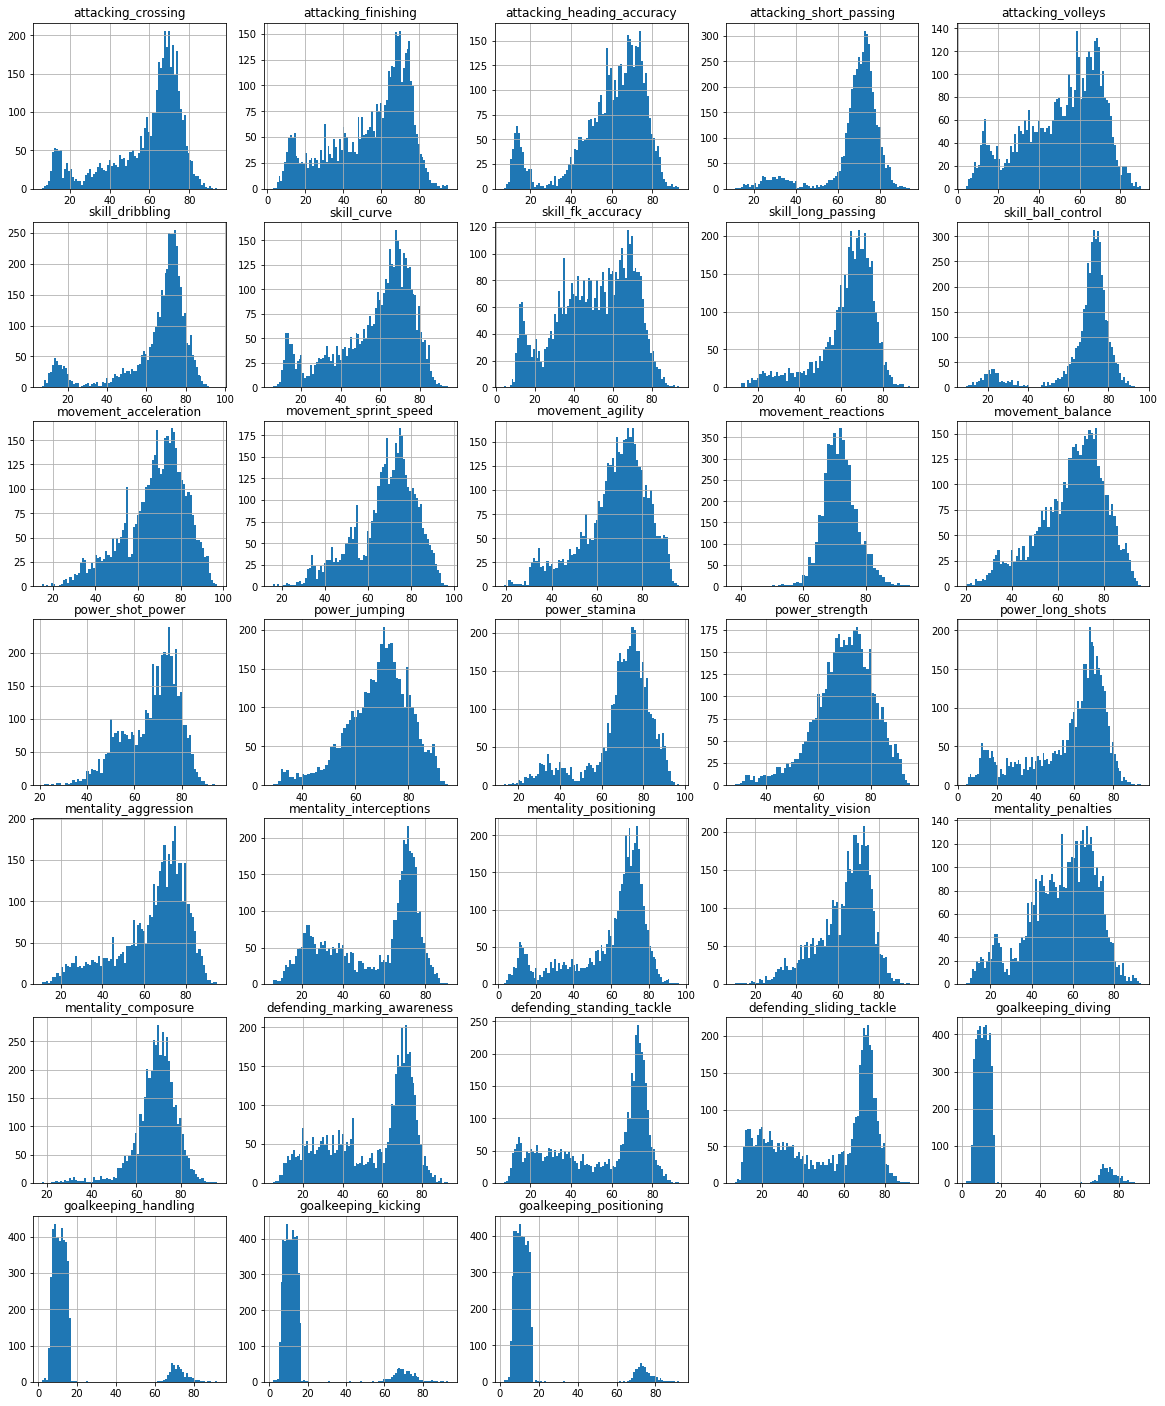

In [ ]:
plt.figure(figsize=(20,25))
#nbins=89
i = 0
for feature in ('attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle',
       'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
       'goalkeeping_positioning'):
  i += 1
  plt.subplot(7,5,i)
  nbins=df_skills[feature].max()-df_skills[feature].min()+1
  df_skills[feature].hist(bins = nbins)  
  plt.title(feature)

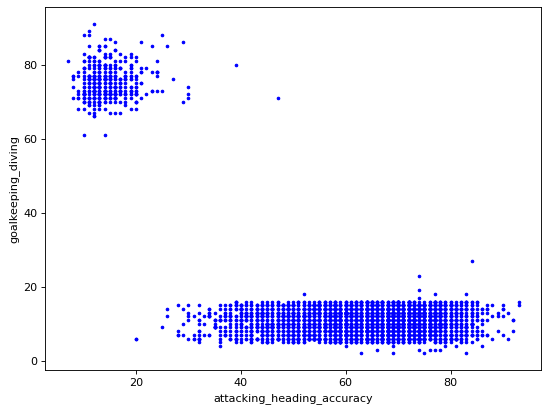

In [ ]:
#Elejimos dos variables, para esto elegimos dos números entre 0 y 34 de df_skills
skill_1=skills_ratings[2]
skill_2=skills_ratings[29]

#Graficamos
plt.figure(figsize=(8,6), dpi=80)
plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=5,c='blue',cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Lo que nos muestran estos gráficos es que al menos existen dos clases muy diferentes que se corresponden a los arqueros y a los jugadores de campo. Esto es fácil de inferir porque todas las skills que empiezan por 'goalkeeping_', son skills propias de los arqueros y de ningun otro jugador de campo.

In [ ]:
# Para una mejor visualización de que significan las siglas de cada posición
# presentamos el siguiente diagrama de posiciones, donde cada posicion es inscripta
# en la region del campo de juego correspondiente:
#____________________________
#|     |   LS ST RS   |      |
#| LW  |  LF      RF  |   RW |
#|     |______________|      |
#|            CF             |    ^
#|        LAM CAM RAM        |    | A
#|                           |    | t
#|                           |    | a
#|-LM----LCM--CM--RCM-----RM-|    | q
#|                           |    | u
#|                           |    | e
#|        LDM CDM RDM        |    |
#| LWB  ______________   RWB |
#|  LB |              | RB   |
#|     |  LCB CB RCB  |      |
#|_____|______GK______|______|

# forwards:
# ST = delantero centro (ST=stricker)
# LS,RS = left and rigth strickers
# LF,RF = segundos delanteros
# LW,RW = extremos

# midfielder:
# CF = mediapuntas (son casi delanteros atrasados)
# LAM,CAM,RAM = mediocentros ofensivos
# LM,RM = mediocampistas laterales
# LCM,CM,RCM = mediocampistas centrales
# LDM,CDM,RDM = mediocampistas defensivos 

# defenders:
# RWB,LWB = carrileros (son defensores que pasan al ataque)
# CB,RCB,LCB = defensores centrales
# RB,LB = defensores laterales

In [ ]:
# Creamos una nueva variable categórica de la base, recodificando la posición 
# para simplificar el análisis de los resultados de la visualización y del clustering

forwards=['RF','ST','LW','LF','RS','LS','RW']
midfielders=['CF','LAM','CAM','RAM','LM','LCM','CM','RM','RCM','LDM','CDM','RDM']
defenders=['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if position in forwards:
        return 'FW'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in defenders:
        return 'D'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

Vamos a separa el dataframe df_n en cuatro dataframes nuevos segun la posición simplificada, definida arriba. Esto, solo con el fin de hacer un análisis exploratório.

In [ ]:
# DF de arqueros
df_arq = pd.DataFrame()
df_arq = df_n.copy()
df_arq["player_positions"] = df_arq["player_positions1"].apply(lambda x: pos2(x))
df_arq = df_arq.drop(df_arq[df_arq['player_positions']=='D'].index)
df_arq = df_arq.drop(df_arq[df_arq['player_positions']=='MF'].index)
df_arq = df_arq.drop(df_arq[df_arq['player_positions']=='FW'].index)
df_arq = df_arq.fillna(0)

In [ ]:
# DF de defensores
df_def = pd.DataFrame()
df_def = df_n.copy()
df_def["player_positions"] = df_def["player_positions1"].apply(lambda x: pos2(x))
df_def = df_def.drop(df_def[df_def['player_positions']=='GK'].index)
df_def = df_def.drop(df_def[df_def['player_positions']=='MF'].index)
df_def = df_def.drop(df_def[df_def['player_positions']=='FW'].index)
df_def = df_def.fillna(0)

In [ ]:
# DF de mediocampistas
df_med = pd.DataFrame()
df_med = df_n.copy()
df_med["player_positions"] = df_med["player_positions1"].apply(lambda x: pos2(x))
df_med = df_med.drop(df_med[df_med['player_positions']=='GK'].index)
df_med = df_med.drop(df_med[df_med['player_positions']=='D'].index)
df_med = df_med.drop(df_med[df_med['player_positions']=='FW'].index)
df_med = df_med.fillna(0)

In [ ]:
# DF de delanteros
df_del = pd.DataFrame()
df_del = df_n.copy()
df_del["player_positions"] = df_del["player_positions1"].apply(lambda x: pos2(x))
df_del = df_del.drop(df_del[df_del['player_positions']=='GK'].index)
df_del = df_del.drop(df_del[df_del['player_positions']=='D'].index)
df_del = df_del.drop(df_del[df_del['player_positions']=='MF'].index)
df_del = df_del.fillna(0)

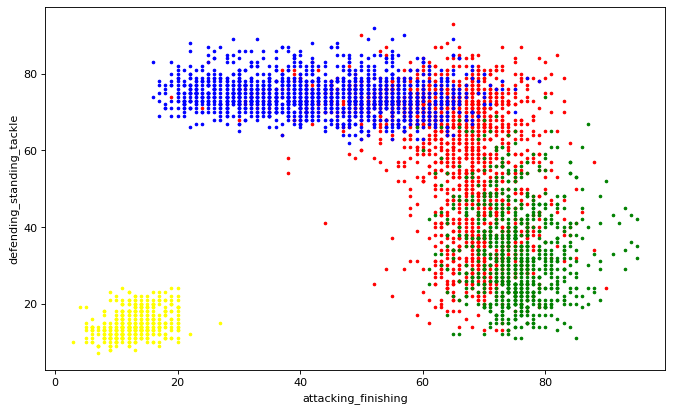

In [ ]:
#Elejimos dos variables, para esto elegimos dos números entre 0 y 34 de df_skills
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

#Graficamos
plt.figure(figsize=(10,6), dpi=80)
plt.scatter(df_arq[skill_1], y=df_arq[skill_2],s=5,c='yellow',cmap='jet')
plt.scatter(df_med[skill_1], y=df_med[skill_2],s=5,c='red',cmap='jet')
plt.scatter(df_def[skill_1], y=df_def[skill_2],s=5,c='blue',cmap='jet')
plt.scatter(df_del[skill_1], y=df_del[skill_2],s=5,c='green',cmap='jet')
plt.xlabel(skill_1)
plt.ylabel(skill_2)
plt.show()

Para este grafico decidimos plotear una variable defensiva en funcion de una variable ofensiva. La idea es que un **delantero** tendrá la variable ofensiva muy alta y la defensiva muy baja. Un **defensor**, por el contrario, esperamos que tenga la variable ofensiva muy baja y la defensiva muy alta. Para los **mediocampistas**, en cambio, esperamos valores intermedios ya que no deberian tener tan desarrolladas estas habilidades (sino seria mejores delanteros o defensores, respectivamente). En el caso de los arqueros, al tener habilidades especificas para esta posicion, esperamos que tengan ambas habilidades bajas.

## 3.2-PCA

En esta subsección vamos a calcular las componentes principales y vamos a graficar haciendo una proyección sobre las dos más importantes.

In [ ]:
df_clusters = df_n.copy()
df_clusters["Position_red4"]=df_clusters["player_positions1"].apply(lambda x: pos2(x))
df_clusters["Position_red4"].value_counts()

MF    1829
D     1485
FW     835
GK     444
Name: Position_red4, dtype: int64

In [ ]:
# Se divide la matriz del dataset en dos partes
X = df_skills.iloc[:,0:35].values
y = df_clusters.iloc[:,67].values

# Normalizamos
X_std = StandardScaler().fit_transform(X)

In [ ]:
# Calculamos la matriz de covarianza
cov_mat = np.cov(X_std.T)
print('NumPy covariance matrix: \n%s' %cov_mat)

# Calculamos los autovalores y autovectores de la matriz
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

NumPy covariance matrix: 
[[ 1.00021777  0.69607543  0.41562699 ... -0.7369623  -0.73533952
  -0.72535917]
 [ 0.69607543  1.00021777  0.42151569 ... -0.64246455 -0.64182105
  -0.63500707]
 [ 0.41562699  0.42151569  1.00021777 ... -0.76958394 -0.77167088
  -0.76411   ]
 ...
 [-0.7369623  -0.64246455 -0.76958394 ...  1.00021777  0.97750882
   0.96445284]
 [-0.73533952 -0.64182105 -0.77167088 ...  0.97750882  1.00021777
   0.9673573 ]
 [-0.72535917 -0.63500707 -0.76411    ...  0.96445284  0.9673573
   1.00021777]]
Eigenvectors 
[[-1.99208882e-01 -5.84162267e-02  1.28692106e-01 ... -2.49634287e-02
   1.16431780e-02  1.48643246e-04]
 [-1.81740632e-01 -1.96302458e-01 -1.51998812e-01 ...  3.23867436e-02
   1.13920817e-02  1.37023393e-02]
 [-1.51268105e-01  1.90145947e-01 -2.42300125e-01 ... -9.28193965e-03
  -2.92588143e-03  5.40147695e-03]
 ...
 [ 2.09102058e-01 -9.43301362e-02 -1.16847579e-02 ... -4.73282802e-02
   8.47638355e-01 -6.45284918e-02]
 [ 2.09087499e-01 -9.59997022e-02 -7.2568902

In [ ]:
#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
19.31372531738192
5.724117264981918
2.1033454617242957
1.776003026252939
1.3386889280048528
0.6916946925283295
0.5645307074678878
0.38035657324640026
0.3239124957160656
0.3140333266429881
0.2715374521841361
0.2325200167910027
0.22596117570430177
0.21165448366297399
0.19285839573668306
0.1494160451193574
0.14493833373296022
0.1270668773290044
0.12017687250708034
0.10019707464825704
0.09367110741015086
0.07673851187475805
0.07227924706720053
0.06505970361588272
0.06324326647219566
0.05283569117731734
0.04871556265957003
0.04763135743801475
0.036299939517262604
0.029420332526708497
0.02614266858302386
0.023979446159416364
0.022856266668714206
0.02156466399294329
0.02044966469302106


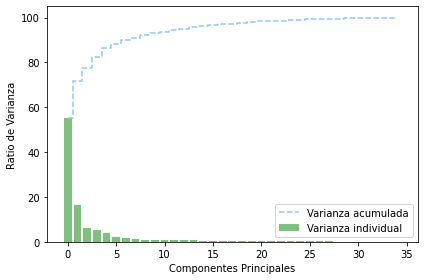

In [ ]:
# A partir de los autovalores, calculamos la varianza y la varianza acumulada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza por cada autovalor y la varinza acumulada
with plt.style.context('seaborn-pastel'):
     plt.figure(figsize=(6, 4))

     plt.bar(range(35), var_exp, alpha=0.5, align='center',
     label='Varianza individual', color='green')
     plt.step(range(35), cum_var_exp, where='mid', linestyle='--', label='Varianza acumulada')
     plt.ylabel('Ratio de Varianza')
     plt.xlabel('Componentes Principales')
     plt.legend(loc='best')
     plt.tight_layout()

Las dos primeras componentes expican más del 70% de la varianza.

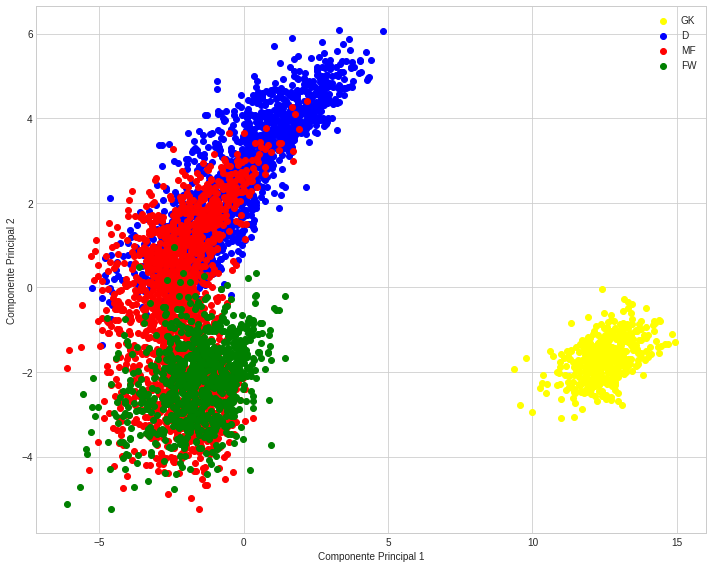

In [ ]:
#Generamos la matríz de proyección a partir de los pares autovalor-autovector
matrix_w = np.hstack((eig_pairs[0][1].reshape(35,1),
                      eig_pairs[1][1].reshape(35,1)))

Y = X_std.dot(matrix_w)

with plt.style.context('seaborn-whitegrid'):
     plt.figure(figsize=(10, 8))
     for lab, col in zip(('GK','D','MF','FW'),
                        ('yellow','blue','red','green')):
         plt.scatter(Y[y==lab, 0],
                     Y[y==lab, 1],
                     label=lab,
                     c=col)
     plt.xlabel('Componente Principal 1')
     plt.ylabel('Componente Principal 2')
     plt.legend(loc='upper right')
     plt.tight_layout()
     plt.show() 

Al igual que en el grafico de una habilidad ofensiva en función de otra defensiva, el grafico de las componentes principales permite diferenciar claramente entre los arqueros y los jugadores de campo. Sin embargo, la separacion entre defensores, mediocampistas y delanteros no parece tan obvia, al mismo tiempo que sin la información prevista por la etiqueta de posición, el gráfico de las dos principales componentes hace muy difícil la interpretación de los clusters.

A continuacion veremos que pasa si retiramos las skills de arqueros y repetimos el PCA para jugadores de campo

In [ ]:
# DF sin arqueros
df_cam = pd.DataFrame()
df_cam = df_n
df_cam = df_cam.drop(df_cam[df_cam['player_positions1']=='GK'].index)
skills_ratings_cam = ['attacking_crossing','attacking_finishing',
       'attacking_heading_accuracy','attacking_short_passing',
       'attacking_volleys','skill_dribbling',
       'skill_curve','skill_fk_accuracy','skill_long_passing',
       'skill_ball_control','movement_acceleration','movement_sprint_speed',
       'movement_agility','movement_reactions','movement_balance',
       'power_shot_power','power_jumping','power_stamina','power_strength',
       'power_long_shots','mentality_aggression','mentality_interceptions',
       'mentality_positioning','mentality_vision','mentality_penalties',
       'mentality_composure','defending_marking_awareness',
       'defending_standing_tackle','defending_sliding_tackle']

print(len(skills_ratings_cam), 'variables numéricas: skills/habilidades')
df_skills_cam = df_cam[skills_ratings_cam]
df_skills_cam = df_skills_cam.fillna(0)

29 variables numéricas: skills/habilidades


In [ ]:
df_clusters_cam = df_cam.copy()
df_clusters_cam["Position_red4"]=df_clusters_cam["player_positions1"].apply(lambda x: pos2(x))
df_clusters_cam["Position_red4"].value_counts()

MF    1829
D     1485
FW     835
Name: Position_red4, dtype: int64

In [ ]:
# Se divide la matriz del dataset en dos partes

X = df_skills_cam.iloc[:,0:29].values
y = df_clusters_cam.iloc[:,67].values

# Normalizamos
X_std = StandardScaler().fit_transform(X)

In [ ]:
# Calculamos la matriz de covarianza
cov_mat = np.cov(X_std.T)
print('NumPy covariance matrix: \n%s' %cov_mat)

# Calculamos los autovalores y autovectores de la matriz
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

NumPy covariance matrix: 
[[ 1.00024108  0.41425955 -0.41858463  0.49447962  0.42810111  0.6810492
   0.7217105   0.57433364  0.42675139  0.60969421  0.45814636  0.35022584
   0.58480839  0.21130243  0.55305517  0.37620274 -0.20993926  0.24002021
  -0.47076257  0.52637651 -0.20833266 -0.0674995   0.57390909  0.63231707
   0.331982    0.27532266 -0.10396999 -0.08625257 -0.08366576]
 [ 0.41425955  1.00024108 -0.19684951  0.33326292  0.84107804  0.71163028
   0.62522616  0.54873756  0.07023617  0.66066812  0.37696544  0.28695122
   0.49505345  0.27074333  0.38243565  0.69969562 -0.17298566  0.05137538
  -0.25284069  0.81397777 -0.37908176 -0.63410203  0.86059566  0.66777845
   0.73054279  0.36701294 -0.65439749 -0.65182635 -0.67928938]
 [-0.41858463 -0.19684951  1.00024108 -0.1932188  -0.14237097 -0.42014305
  -0.38553339 -0.36227051 -0.21514123 -0.28961875 -0.41845063 -0.24564653
  -0.5475268   0.19797509 -0.56730856 -0.06628868  0.47541715 -0.08283626
   0.66566706 -0.27937567  0.412453

In [ ]:
#  Hacemos una lista de parejas (autovector, autovalor) 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordenamos estas parejas den orden descendiente con la función sort
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visualizamos la lista de autovalores en orden desdenciente
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendiente:
11.880644433229218
4.680598538307582
3.1642637787515553
1.9384665854636842
1.0547972322514445
0.7601736374924442
0.5950879466021815
0.551848672204537
0.47280739963904844
0.4522070989919585
0.38161110992644354
0.3601365373891076
0.3310228141800549
0.26147438012870233
0.2565682989516319
0.22786676157813246
0.2243313552201024
0.19658603039848174
0.17524133095944242
0.16660370862956905
0.14312525265996262
0.14026805401208725
0.12322261033011825
0.10224088851409029
0.09669574045817672
0.08933831360608704
0.08436851208737796
0.0663670731017648
0.02902722605360053


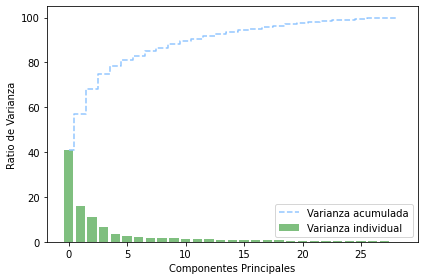

In [ ]:
# A partir de los autovalores, calculamos la varianza
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Representamos en un diagrama de barras la varianza por cada autovalor, y la acumulada
with plt.style.context('seaborn-pastel'):
     plt.figure(figsize=(6, 4))

     plt.bar(range(29), var_exp, alpha=0.5, align='center',
     label='Varianza individual', color='green')
     plt.step(range(29), cum_var_exp, where='mid', linestyle='--', label='Varianza acumulada')
     plt.ylabel('Ratio de Varianza')
     plt.xlabel('Componentes Principales')
     plt.legend(loc='best')
     plt.tight_layout()

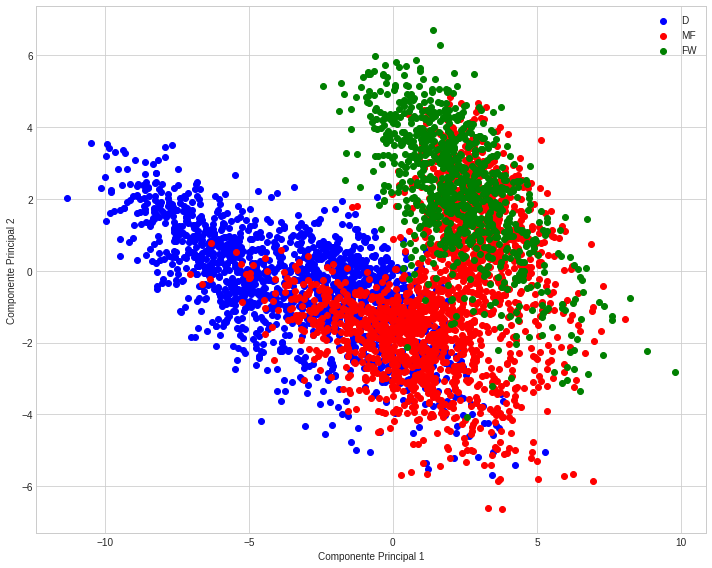

In [ ]:
#Generamos la matríz a partir de los pares autovalor-autovector
matrix_w = np.hstack((eig_pairs[0][1].reshape(29,1),
                      eig_pairs[1][1].reshape(29,1)))

Y = X_std.dot(matrix_w)

with plt.style.context('seaborn-whitegrid'):
     plt.figure(figsize=(10, 8))
     for lab, col in zip(('D','MF','FW'),
                        ('blue','red','green')):
         plt.scatter(Y[y==lab, 0],
                     Y[y==lab, 1],
                     label=lab,
                     c=col)
     plt.xlabel('Componente Principal 1')
     plt.ylabel('Componente Principal 2')
     plt.legend(loc='upper right')
     plt.tight_layout()
     plt.show()

# 4.-Clustering

En las siguientes secciones apicaremos 3 tecnicas de custering con la particularidad que no vamos a utilizar la etiqueta en la etapa de entrenamiento. Dicho de otra forma, los datos serán analizados de forma agnóstica al target.

## 4.1-Clustering con Kmeans

In [ ]:
# Número de clusters buscado
n_clust = 4
km = KMeans(n_clusters=n_clust).fit(df_skills) #utiliza todas las habilidades: 35 dimensiones

# Etiquetas asignadas por el algoritmo
clusters4 = km.labels_
print('Suma de los cuadrados de las distancias al centro de cada cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al centro de cada cluster=Inertia=  11553599.174627902


In [ ]:
df_clusters = df_n.copy()
df_clusters['kmeans_4'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
#df_clusters4.head(4)

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez

In [ ]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"] < 86

#Eligo dos números entre 0 y 35 de df_skills
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
kmean_clusters = go.Scatter(x=df_n[skill_1], y=df_n[skill_2],
                           mode='markers',
                           text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters4.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_n.loc[bool_crack,skill_1], y=df_n.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]
#data=[kmean_clusters]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab:
fig.show(renderer="colab")

En el grafico vemos como Kmeans separa estas posiciones en cuatro clusters bien definidos. En particular, los arqueros se encuentran bien aislados del resto de los jugadores de campo.

In [ ]:
df_clusters["Position_red4"]=df_clusters["player_positions1"].apply(lambda x: pos2(x))
df_clusters["Position_red4"].value_counts()

MF    1829
D     1485
FW     835
GK     444
Name: Position_red4, dtype: int64

In [ ]:
df_sk4 = pd.DataFrame()
serie = df_clusters.groupby(['Position_red4','kmeans_4']).size()
df_sk4 = serie.to_frame().reset_index()
df_sk4 = df_sk4.rename(columns={'Position_red4':'posicion_FIFA','kmeans_4':'KM4',0:'suma'})
df_sk4

,posicion_FIFA,KM4,suma
0,D,1,650
1,D,3,835
2,FW,0,806
3,FW,1,29
4,GK,2,444
5,MF,0,683
6,MF,1,1046
7,MF,3,100


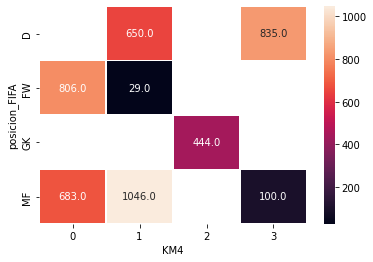

In [ ]:
mapa4 = df_sk4.pivot('posicion_FIFA','KM4','suma')
ax4 = sns.heatmap(mapa4, annot=True, fmt="", linewidths=.5)

En este mapa de calor podemos observar que los clusters encontrados reproducen bastante bien las 4 posiciones básicas del juego. Las mayores concentraciones de cada cluster pertenece a una única posición.

Sin embargo podemos observar que una cantidad importante de jugadores que son defensores o mediocampistas, KM los tiende a clasificar como mediocampistas o delanteros, respectivamente.

Para el caso de arqueros y delanteros, KM logra separar muy bien ambos grupos (el número de errores del modelo parece ser muy bajo).

Este grafico puede estar indicandonos que podriamos considerar subdividir al grupo de los mediocampistas en tres subgrupos: mediocampistas defensivos (más ligado a labores defensivas), mediocampistas ofensivos (ligados a labores ofensivas) y mediocampitas (centrales y laterales).

In [ ]:
# Número de clusters buscado
n_clust6 = 6
km6 = KMeans(n_clusters=n_clust6).fit(df_skills) #utiliza todas las habilidades: 35 dimensiones
clusters6 = km6.labels_
df_clusters['kmeans_6'] = km6.labels_ #clusters
print('Kmeans encontró: ', max(km6.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  6 clusters, nosotros forzamos la cantidad


In [ ]:
#Eligo dos números entre 0 y 35 de df_skills
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

kmean_clusters6 = go.Scatter(x=df_n[skill_1], y=df_n[skill_2],
                           mode='markers',
                           text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters6.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_n.loc[bool_crack,skill_1], y=df_n.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters6,crack]

layout = go.Layout(title="Clustering K means",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab:
fig.show(renderer="colab")

Cuando usamos 6 clusters, puede verse como el cluster de mediocampistas que conectaba los clusters de defensores con el de delanteros, se subdivide en tres nuevos grupos. Uno horizontal en el plano defending-standing-tackle vs. attacking-finishing, correspondiente a los mediocampistas defensivos (tiene valores defensivos altos y skills ofensivas entre medio y altas), y un segundo grupo, vertical en dicho plano, correspondiente a los mediocampistas ofensivos (tiene valores ofensivos altos y skills defensivas entre medio y altas).

In [ ]:
# Creamos una nueva variable categórica de la base recodificando la posición 
# para simplificar el análisis de los resultados de clustering

forwards=['LF','RF','LW','RW','LS','RS','ST']
midfielders_of=['CF','LAM','CAM','RAM']
midfielders=['LM','LCM','CM','RCM','RM']
midfielders_def=['LDM','CDM','RDM']
defenders=['LWB','RWB','RCB','CB','LCB','LB','RB']
goalkeepers=['GK']

def pos3(position):
    if position in forwards:
        return 'FW'
    
    elif position in midfielders_of:
        return 'MF_of'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in midfielders_def:
        return 'MF_def'
    
    elif position in defenders:
        return 'D'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

In [ ]:
df_clusters["Position_red6"]=df_clusters['player_positions1'].apply(lambda x: pos3(x))
df_clusters["Position_red6"].value_counts()

D         1485
MF         996
FW         835
MF_def     445
GK         444
MF_of      388
Name: Position_red6, dtype: int64

In [ ]:
df_sk6 = pd.DataFrame()
serie = df_clusters.groupby(['Position_red6','kmeans_6']).size()
df_sk6 = serie.to_frame().reset_index()
df_sk6 = df_sk6.rename(columns={'Position_red6':'posicion_FIFA','kmeans_6':'KM6',0:'suma'})
df_sk6

,posicion_FIFA,KM6,suma
0,D,2,668
1,D,3,212
2,D,5,605
3,FW,0,293
4,FW,2,2
5,FW,3,25
6,FW,4,515
7,GK,1,444
8,MF,0,388
9,MF,2,61


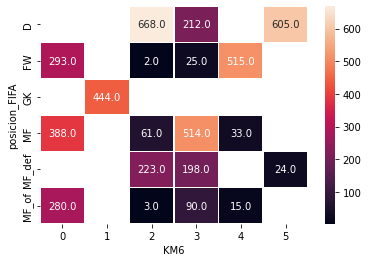

In [ ]:
mapa6 = df_sk6.pivot('posicion_FIFA','KM6','suma')
ax6 = sns.heatmap(mapa6, annot=True, fmt="", linewidths=.5)

In [ ]:
# GK     = 1
# D      = 5
# MF_def = 2
# MF     = 3
# MF_of  = 0
# FW     = 4

Sin embargo el mapa de calor para 6 clusters no parece mejorar y aun presenta algunas ambiguedades, como es el caso de los delanteros con los mediocampistas ofensivos y con los mediocampistas. Aunque a cada uno de estos clusters le corresponde el grupo más numeroso, existe una cantidad grande de delanteros y de mediocampistas que son asociados al cluster de los mediocampistas ofensivos.
Esto tambien ocurre entre los defensores, los mediocampistas defensivos y los mediocampistas.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

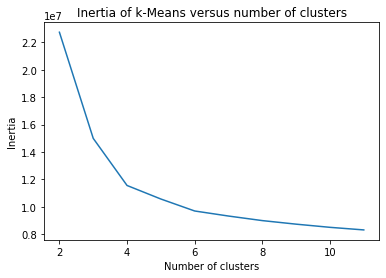

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2,12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Este grafico nos dice que usando el concepto de inercia, la cantidad optima de clusters es en torno a 4. Despues de este valor, la ganancia es cada vez menor con el aumento del numero de clusters

## 4.2-Clustering con Mean Shifts

In [ ]:
df_ms = pd.DataFrame(columns=['Bandwidth','Clusters'])
band = 34.0
while band < 44.5:
  ms = MeanShift(bandwidth=band, bin_seeding=True)
  ms.fit(df_skills)
  clusters = ms.labels_
  labels_unique = np.unique(clusters)
  n_clusters_ = len(labels_unique)
  df_ms = df_ms.append({'Bandwidth': band,'Clusters': n_clusters_}, ignore_index=True)
  band = band+0.1

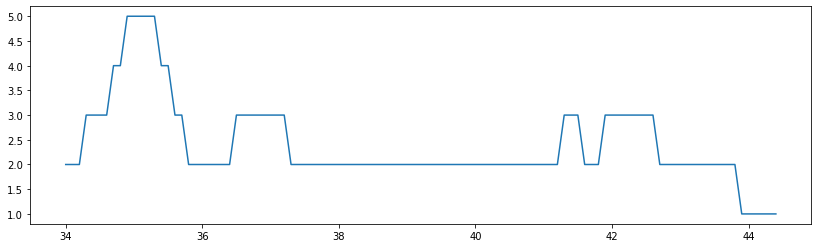

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df_ms['Bandwidth'],df_ms['Clusters'])
plt.show()

El rango de bandwidth que encontramos para un numero razonable de clusters con Mean Shift está en el intervalo (34.0,44.4). Fuera de este intervalo obtenemos mas de 4000 clusters, o 1 o ninguno.

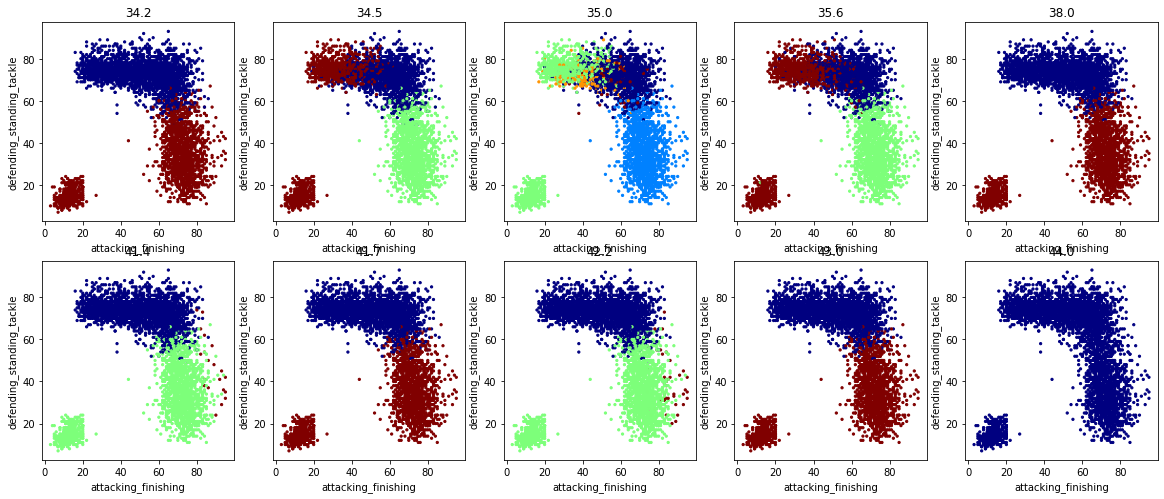

In [ ]:
#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

plt.figure(figsize=(20,30))
i = 0
#for feature in [34.1,34.5,35.0,35.6,38.0,41.4,41.7,42.2,43.0,44.0]:
for band in [34.2,34.5,35.0,35.6,38.0,41.4,41.7,42.2,43.0,44.0]:
  i += 1
  ms = MeanShift(bandwidth=band, bin_seeding=True)   # 35.8-35.7   tres GK+DF; MF y FW
  ms.fit(df_skills)
  clusters = ms.labels_
  cluster_centers = ms.cluster_centers_
  labels_unique = np.unique(clusters)
  n_clusters_ = len(labels_unique)

  df_temp = pd.DataFrame()
  df_temp = df_skills.copy()
  df_temp['Color'] = clusters
  plt.subplot(7,5,i)
  plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=5,c=clusters,cmap='jet')
  plt.xlabel(skill_1)
  plt.ylabel(skill_2)
  plt.title(band)
plt.show()

En este grafico mostramos que el intervalo de Bandwidth (34.3,35.7), los modelos con Means Shift dan resultados compatibles con los resultados obtenidos por Kmeans. En este rango obtenemos tres grandes grupos: arqueros+defensores, mediocampistas y delanteros. En los casos donde Means Shift obtiene cuatro o cinco clusters, estos clusters extras son muy poco numerosos y aislados.

In [ ]:
ms = MeanShift(bandwidth=34.5, bin_seeding=True)
ms.fit(df_skills)

clusters_ms = ms.labels_
cluster_centers = ms.cluster_centers_
df_clusters['Mean Shift'] = ms.labels_ #clusters

labels_unique = np.unique(clusters_ms)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


In [ ]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters_ms.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

Los mejores resultados que se obtienen con Mean Shift ocurren un bandwidth en torno de 34.5. En estos casos se obtienen 3 clusters que son compatibles con los cuatro encontrados por kmeans, con la diferencia que los clusters de defensores y arqueros, Mean Shift los asigna a un unico grupo.

In [ ]:
# Creamos una nueva variable categórica de la base recodificando la posición 
# para simplificar el análisis de los resultados de clustering

forwards=['RF','ST','LW','LF','RS','LS','RW']
midfielders=['CF','LAM','CAM','RAM','LM','LCM','CM','RM','RCM','LDM','CDM','RDM']
defenders=['GK','RCB','CB','LCB','LB','RB','RWB','LWB']
#goalkeepers=[]

def pos4(position):
    if position in forwards:
        return 'FW'
    
    elif position in midfielders:
        return 'MF'
    
    elif position in defenders:
        return 'D'
    
#    elif position in goalkeepers:
#        return 'GK'
    
    else:
        return 'nan'

In [ ]:
df_clusters["Position_red3"]=df_clusters["player_positions1"].apply(lambda x: pos4(x))
df_clusters["Position_red3"].value_counts()

D     1929
MF    1829
FW     835
Name: Position_red3, dtype: int64

In [ ]:
df_sk_ms = pd.DataFrame()
serie = df_clusters.groupby(['Position_red3','Mean Shift']).size()
df_sk_ms = serie.to_frame().reset_index()
df_sk_ms = df_sk_ms.rename(columns={'Position_red3':'posicion_FIFA','Mean Shift':'MS',0:'suma'})
df_sk_ms

,posicion_FIFA,MS,suma
0,D,0,719
1,D,2,1210
2,FW,0,26
3,FW,1,809
4,MF,0,1051
5,MF,1,711
6,MF,2,67


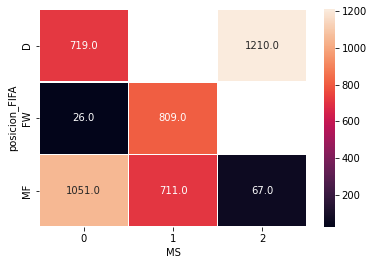

In [ ]:
mapa_ms = df_sk_ms.pivot('posicion_FIFA','MS','suma')
ax_ms = sns.heatmap(mapa_ms, annot=True, fmt="", linewidths=.5)

El mapa de calor tambien es compatible con el mapa de calor del KMeans de 4 clusters. El cluster de delanteros está muy bien definido y el correspondiente a defensores+arqueros contiene muchos mediocamistas y viceversa.

## 4.3-Clustering con DBSCAN

Para el caso de DBscan, vamos a fijar min_samples en un valor de 5 y vamos a variar el hiperparámetro eps hasta 100. 

In [ ]:
df_db = pd.DataFrame(columns=['Eps','Clusters'])
band = 1
while band < 101:
  db = DBSCAN(eps=band,min_samples=5)
  db.fit(df_skills)
  clusters = db.labels_
  cluster_centers = db.components_
  labels_unique = np.unique(clusters)
  n_clusters_ = len(labels_unique)
  df_db = df_db.append({'Eps': band,'Clusters': n_clusters_}, ignore_index=True)
  band += 1

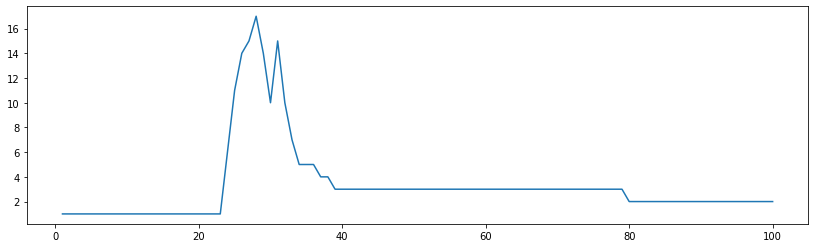

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df_db['Eps'],df_db['Clusters'])
plt.show()

Este grafico parece indicarnos que en el rango de eps de 40 a 80, la cantidad de clusters encontrados es 3. Vamos a analizar si estos modelos son compatibles con los modelos utilizados en las secciones anteriores.

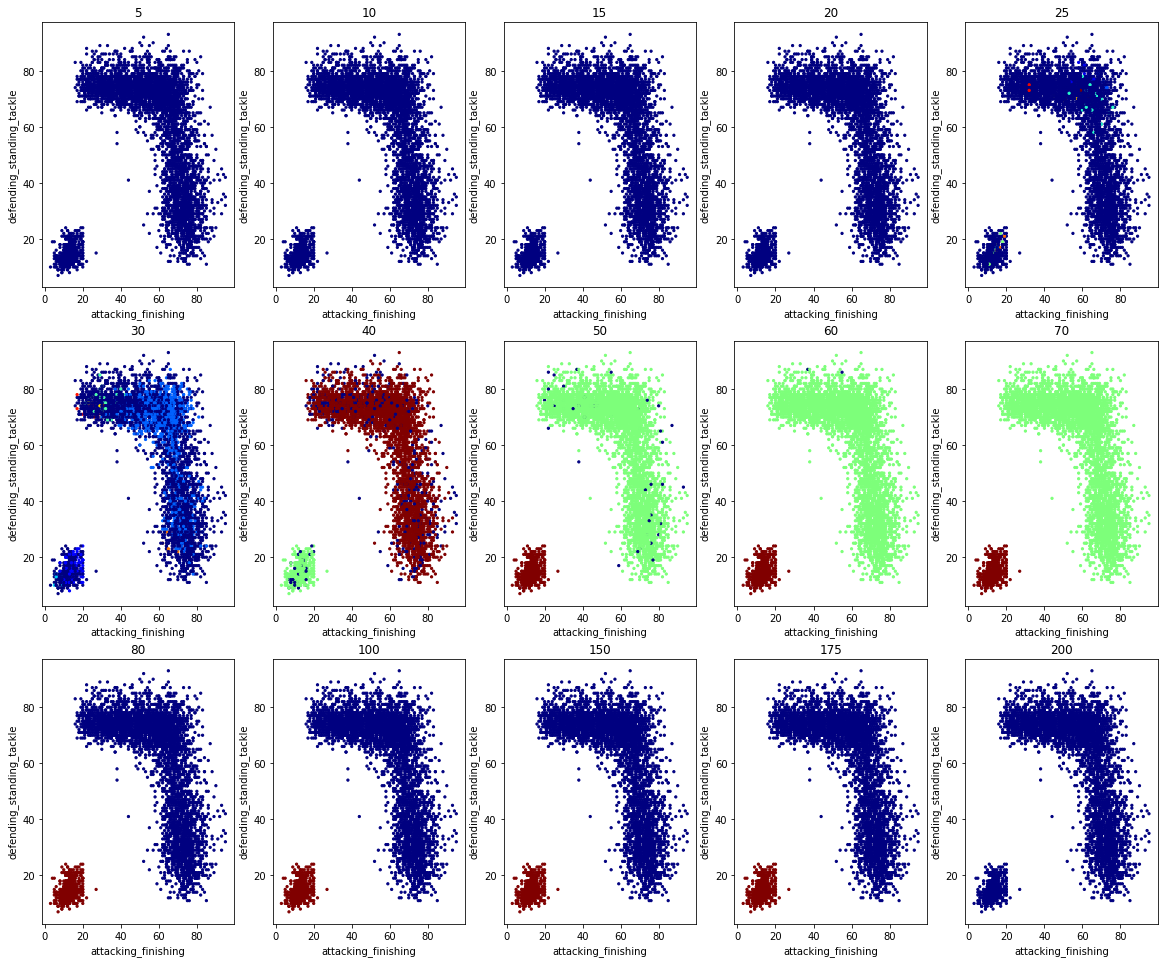

In [ ]:
#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

plt.figure(figsize=(20,40))
i = 0
for band in [5,10,15,20,25,30,40,50,60,70,80,100,150,175,200]:
#for band in [5,10,15,20,25,30,60,90]:
  i += 1
  db = DBSCAN(eps=band,min_samples=5)
  db.fit(df_skills)
  clusters = db.labels_
  cluster_centers = db.components_
  labels_unique = np.unique(clusters)
  n_clusters_ = len(labels_unique)

  df_temp = pd.DataFrame()
  df_temp = df_skills.copy()
  df_temp['Color'] = clusters
  plt.subplot(7,5,i)
  plt.scatter(df_skills[skill_1], y=df_skills[skill_2],s=5,c=clusters,cmap='jet')
  plt.xlabel(skill_1)
  plt.ylabel(skill_2)
  plt.title(band)
plt.show()

Estas figuras nos muestran que en general, DBSCAN encuentra solamente uno o dos clusters reales. Cuando es uno, es todo el dataframe. Cuando son dos, son por un lado los arqueros y por otro lado los jugadores de campo. Todos los otros clusters que este metodo encuentra corresponden a clustersde muy poquitos elementos y generalmente aislados.

In [ ]:
db = DBSCAN(eps=60,min_samples=5).fit(df_skills)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
clusters_db = db.labels_

# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(clusters3)) - (1 if -1 in clusters3 else 0)
n_clusters_ = len(np.unique(clusters_db))
n_noise_ = list(clusters_db).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 3


Graficamos los resultados:

In [ ]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[1]
skill_2=skills_ratings[27]

In [ ]:
data=[]
DBSCAN_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters_db.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[DBSCAN_clusters,crack]

layout = go.Layout(title="DBSCAN",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [ ]:
#En Colab
fig.show(renderer="colab")

En esta figura podemos observar como para un eps de 60, tenemos tres clusters: El correspondiente a los arqueros, el correspondiente a los jugadores de campo y un tercero espureo de solo unos pocos jugadores aislados (en la parte superior del gráfico).

# 5.-Discusión

En este entregable utilizamos el dataset de jugadores de FIFA 2022 disponible en Kaggle (https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset?resource=download&select=players_22.csv). Este dataframe fue curado y utilizamos las variables de skills de los jugadores, asi como su posicion. Esta ultima fue usada como un target oculto para intentar reproducir a partir de tres tecnicas de clustering: KMeans, Mean Shift y DBSCAN. El dataframe de skills no fue normalizado debido a que todas las habilidades ya se encuentran en una escala de 0 a 100. Esto sería diferente si hubieramos utilizado otro tipo de variable, como por ejemplo el sueldo de cada jugador, donde una pequeña variación se llevaría la variacion del resto del df.

Para el grafico de los clusters decidimos utilizar una variable defensiva en funcion de una variable ofensiva. La idea es que un **delantero** tendrá la variable ofensiva muy alta y la defensiva muy baja. Un **defensor**, por el contrario, esperamos que tenga la variable ofensiva muy baja y la defensiva muy alta. Para los **mediocampistas**, en cambio, esperamos valores intermedios ya que no deberian tener tan desarrolladas estas habilidades (sino seria mejores delanteros o defensores, respectivamente). En el caso de los arqueros, al tener habilidades especificas para esta posicion, esperamos que tengan ambas habilidades bajas.

Por otro lado, esto fue contrastado con un gráfico 2D de las dos componentes principales de un PCA. La varianza acumulada de las dos primeras componentes se lleva en torno al 70% de la varianza total del dataframe. Sin embargo, decidimos utilizar el grafico de una variable defensiva en funcion de otra ofensiva debido a que el PCA no presenta una mejora sustancial respecto del anterior, y sumado al inconveniente de la dificultad a la hora de interpretar los resultados obtenidos por los métodos de clustering.

Los resultados para los metodos de clustering propuestos fueron los siguientes:
* **KMeans:** El hiperparámetro explorado fue n_clusters, y a través del concepto de inercia, encontramos que su número optimo es igual a 4. Esto se corresponde con 4 clusters bien definidos, los cuales pueden asociarse a los arqueros, los defensores, los mediocampistas y los delanteros. 
* **Mean Shift:** El hiperparámetro explorado fue bandwidth. El rango de bandwidth que encontramos para un numero razonable de clusters fue el intervalo 34.0-44.4. Fuera de este intervalo obtenemos más de 4000 clusters, o 1 o ninguno. Para un bandwidth en torno de 34.5 se encontraron 3 clusters bien definidos, los cuales corresponden a los arqueros más los defensores, los mediocampistas y los delanteros.
* **DBSCAN:** El hiperparámetro explorado fue eps, mientras que min_samples fue fijado en 5.  El rango de eps en el cual encontramos un numero razonable de clusters fue el intervalo 40-175. Para este rango se encontraron 2 clusters bien definidos, los cuales corresponden a los arqueros y a los jugadores de campo.